In [57]:
import sys
sys.path.insert(0,'C:\\users\\alexa\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import entropy

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""

from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar

from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# Import Data

reader = FamaFrenchReader("49_Industry_Portfolios", start=datetime.datetime(1970, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202210 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (634 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (634 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (52 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (52 rows x 49 cols)\n  4 : Number of Firms in Portfolios (634 rows x 49 cols)\n  5 : Average Firm Size (634 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (53 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (53 rows x 49 cols)'

In [75]:
""" Inputs """

# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

#Weights
w_mc = sector_mkt_cap.divide(total_mkt_cap, axis ="rows")
w_eq = weights = np.repeat(1.0 / 49.0, 49)

# Index Returns
mkt_index = (1 + market_return).cumprod()
eq_index = (1 + equal_weighted_return).cumprod()

# Calculate log returns
log_returns = np.log(1+ind_mc_weighted)
mean_log_returns = log_returns.mean()

# Create Datetime Variable
start = datetime.datetime(1970,1,1)
end = datetime.datetime(2022,11,1)
dates = pd.date_range(start,end-datetime.timedelta(days=1),freq='m')

In [76]:
# Covariance Matrix
cov_mat_log_returns = log_returns.cov()

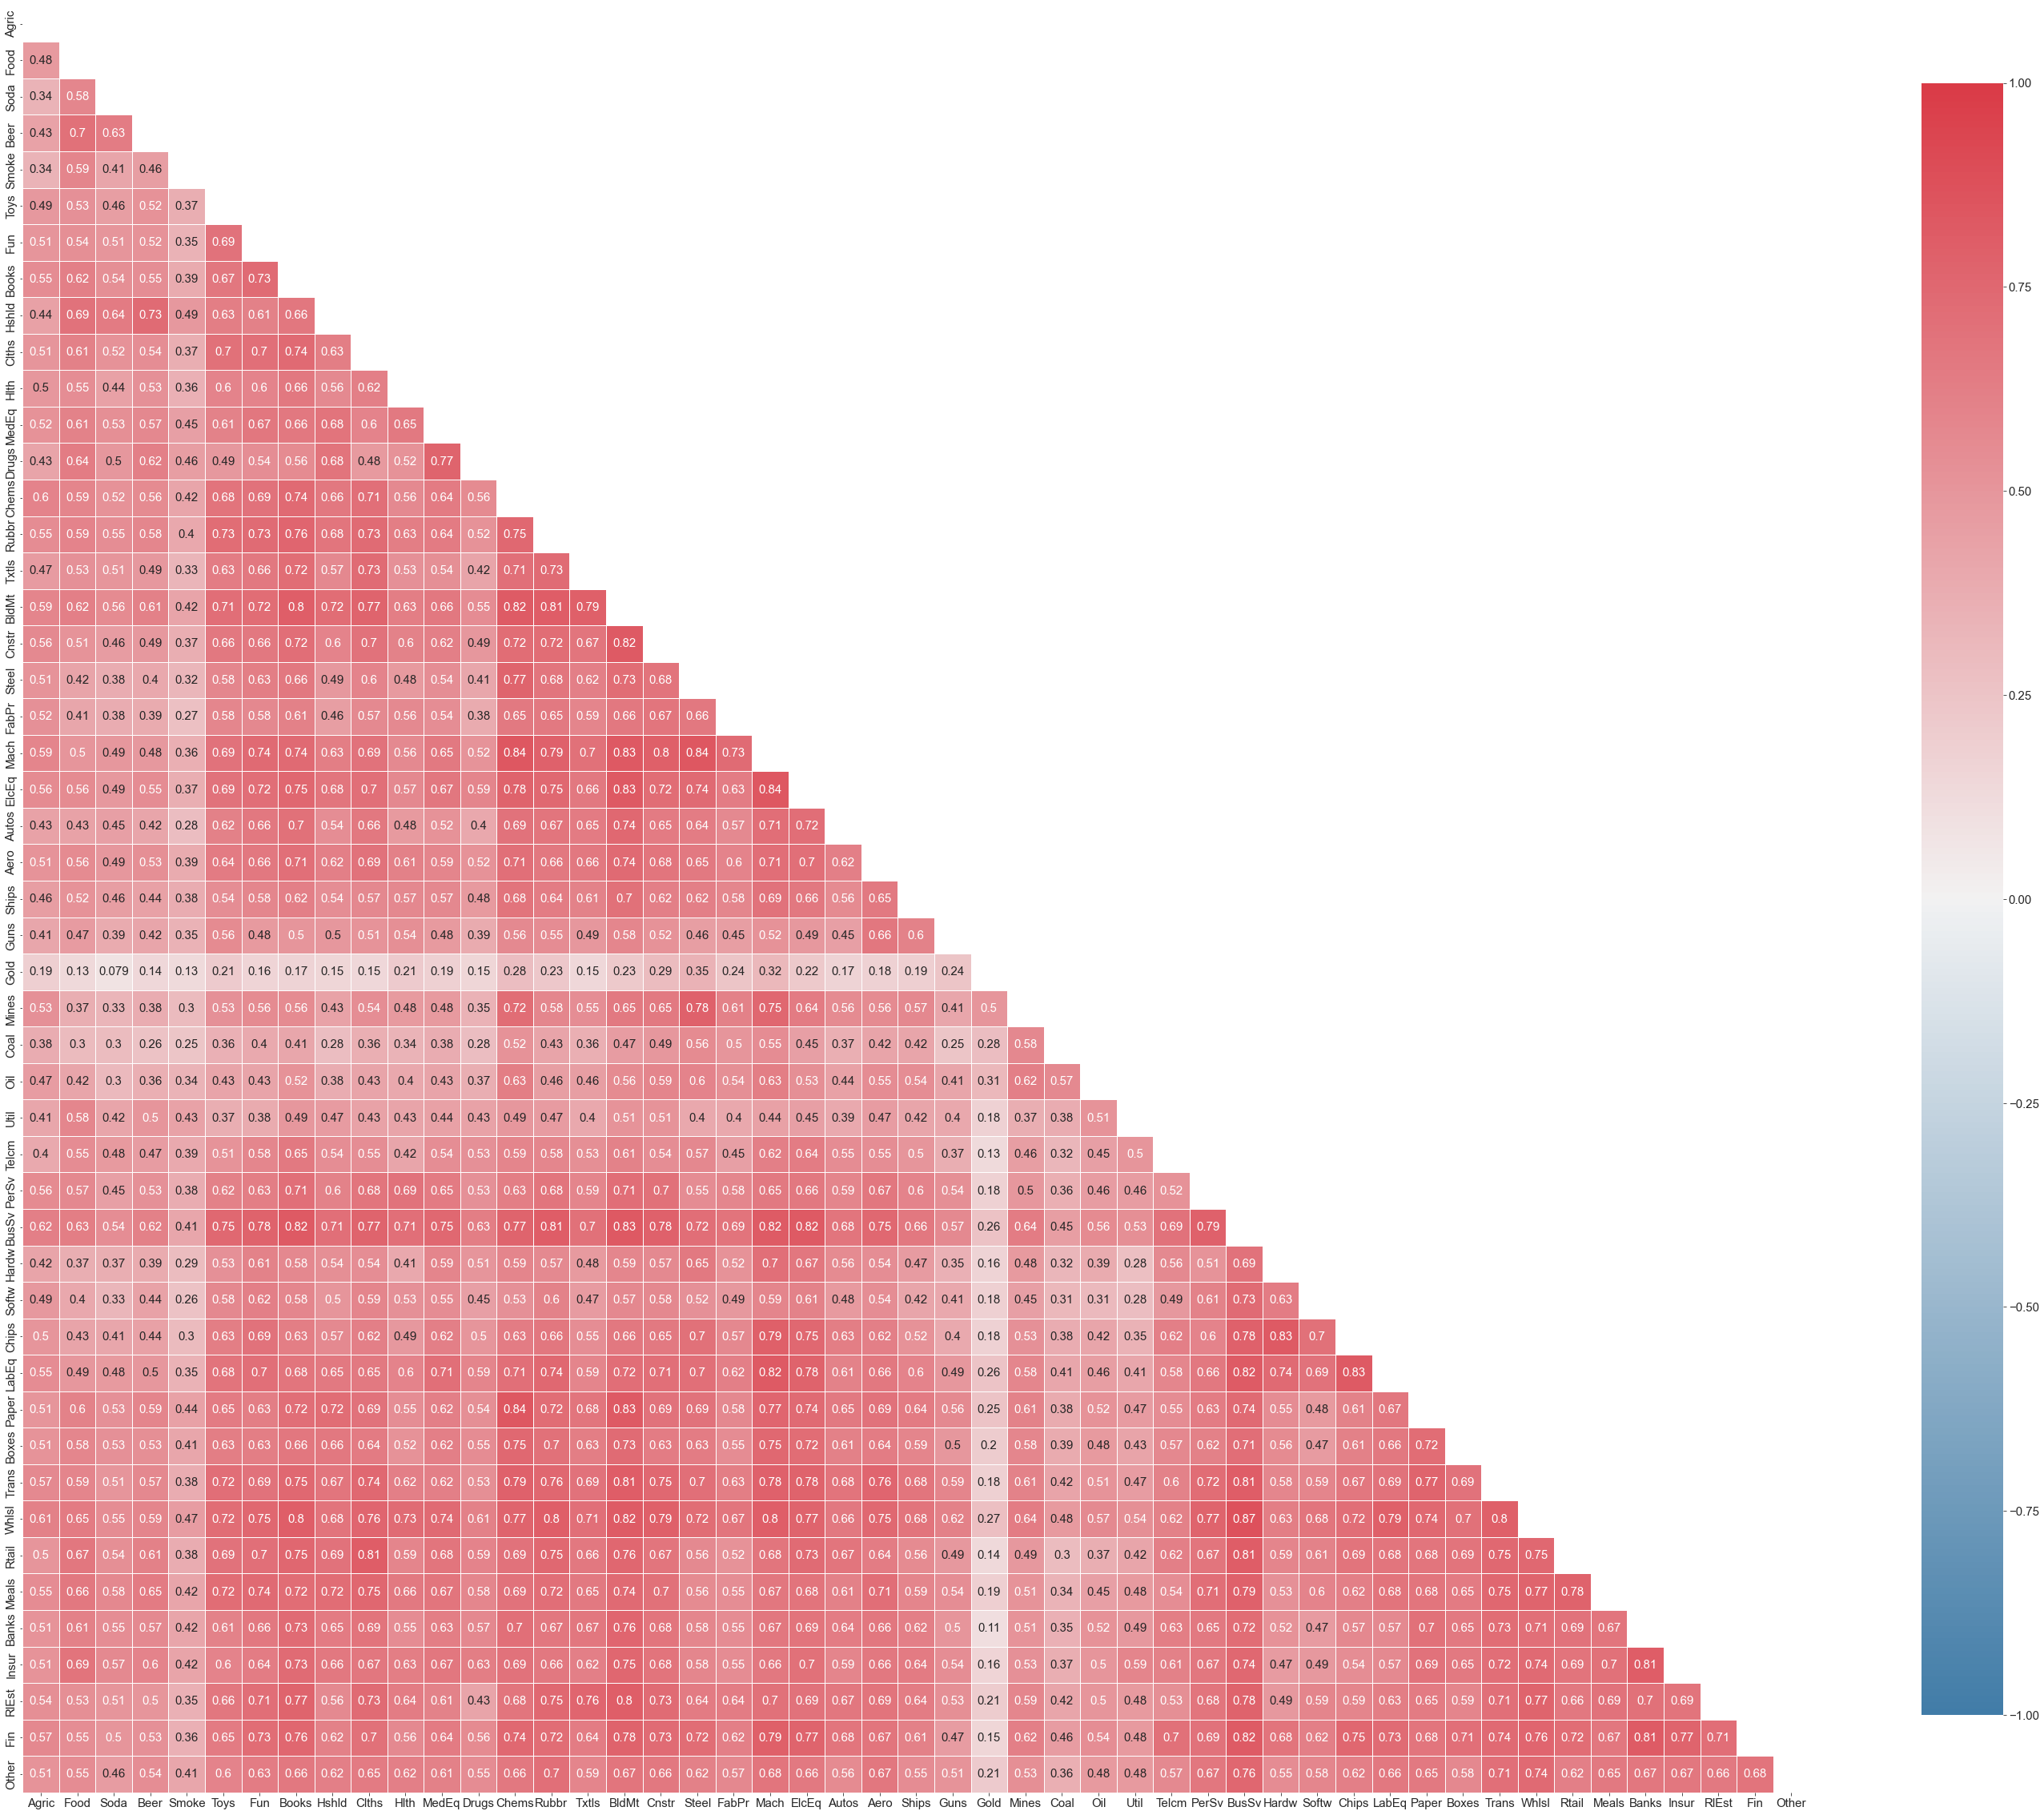

In [77]:
# Plotting Correlation Matrix

corr_mat_log_returns = cov_to_corr_matrix(cov_mat_log_returns)
fig, ax = plt.subplots(figsize=(50, 50))
correlation_plot(corr_mat_log_returns, names=asset_list, include_values=True, ax=ax)

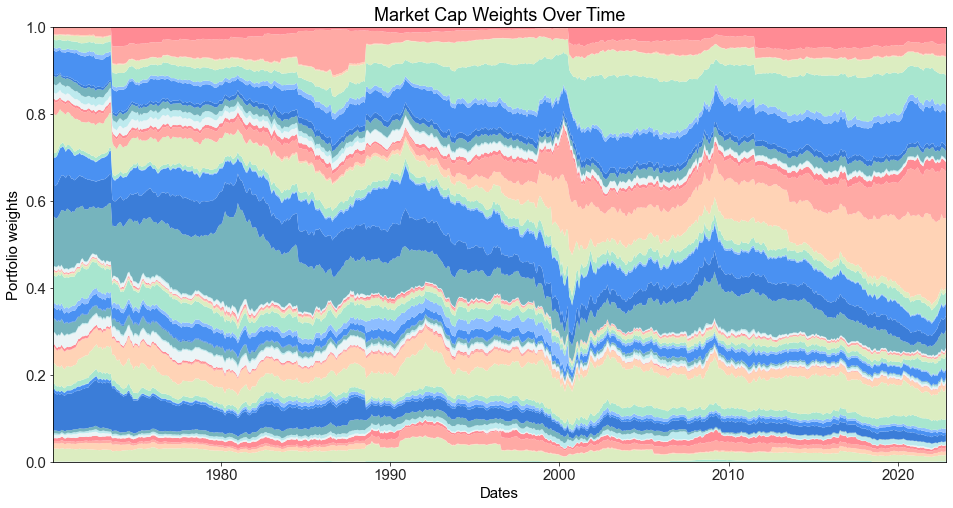

In [65]:
# Plot Market Cap Weights Over Time 

fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(dates, w_mc.T);
ax.set_xlabel("Dates")
ax.set_ylabel("Portfolio weights")
ax.set_title("Market Cap Weights Over Time");

In [101]:
# Sectors that Dominates

w_mc.sum()

Agric     0.976509
Food     15.677386
Soda      3.926562
Beer      8.022698
Smoke     6.699969
Toys      1.862118
Fun       5.142034
Books     5.559192
Hshld    23.238753
Clths     4.161976
Hlth      3.497616
MedEq     8.679446
Drugs    41.993305
Chems    17.699669
Rubbr     1.300106
Txtls     1.361091
BldMt     8.169295
Cnstr     2.465594
Steel     6.349812
FabPr     0.556284
Mach     13.461595
ElcEq     7.402202
Autos    15.512528
Aero      6.987124
Ships     0.849682
Guns      1.680087
Gold      1.284733
Mines     2.717992
Coal      0.732601
Oil      54.494961
Util     33.837436
Telcm    37.855183
PerSv     1.975887
BusSv    11.098811
Hardw    28.819686
Softw    32.946180
Chips    26.616832
LabEq     6.288455
Paper     9.282438
Boxes     3.959881
Trans    11.869083
Whlsl     7.159004
Rtail    38.613643
Meals     7.033560
Banks    42.539753
Insur    24.241022
RlEst     1.013125
Fin      20.932694
Other    15.454405
dtype: float64

In [66]:
# Define ENC Formulas

def calculate_enc(weights: np.ndarray, alpha: int = 1, relative: bool = False) -> float:

    """
    Calculates the effective number of constituents in a long-only portfolio.

    if :math:`\\alpha>0, \\alpha \\neq 1`, then

    .. math::

        \\begin{equation}
            \\text{ENC}(w, \\alpha) = \\Vert w \\Vert_{\\alpha}^{\\frac{\\alpha}{1- \\alpha}}
        \\end{equation}

    Note that :math:`\\alpha = 2` will correspond to the inverse of the Herfindahl index.

    if :math:`\\alpha = 1` then the exponential of the entropy of the portfolio weights

    .. math::

        \\begin{equation}
            \\text{ENC}(w, \\alpha) = \\exp \\left(- \\sum_{i=1}^N w_i \\ln w_i \\right)
        \\end{equation}

    Parameters
    ----------
    weights:
        Portfolio weights.
    alpha:
        Alpha parameter.
    relative:
        Calculate diversification relative to number of assets. Default is False.

    Returns
    -------

    """

    num_constituents = len(weights)
    enc = 0.0

    if alpha <= 0:
        raise ValueError("Alpha must be larger than zero.")
    elif alpha == 1:
        enc = np.exp(entropy(weights, axis = 1))
    else:
        norm = np.linalg.norm(weights, ord=alpha, axis = 1)
        enc = norm**(alpha / (1 - alpha))

    if relative:
        return enc / num_constituents
    else:
        return enc

In [105]:
# Define Weight Input In ENC Formula

weights_ENC = np.array(w_mc).astype(float)

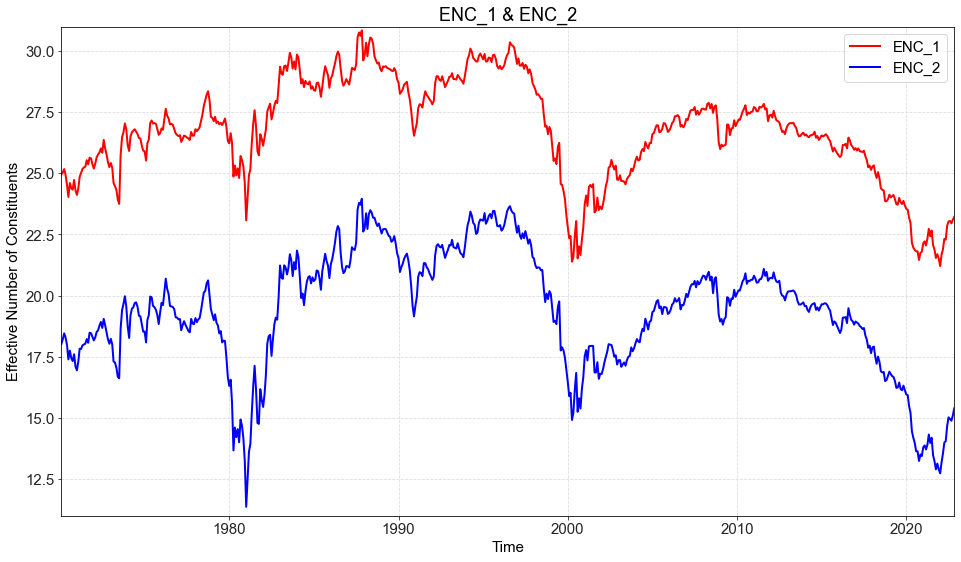

In [82]:
# Plot ENC_2

fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(dates, calculate_enc(weights_ENC, 1), color='r', label='ENC_1')
plt.plot(dates, calculate_enc(weights_ENC, 2), color='b', label='ENC_2')
plt.ylim((11,31))
plt.xlabel("Time")
plt.ylabel("Effective Number of Constituents")
plt.title("ENC_1 & ENC_2")
plt.legend()

In [106]:
# Defining Risk Contributions

def calculate_risk_contribution(weights: np.ndarray, cov_matrix: np.ndarray, Months: int) -> np.ndarray:
    
    """
    Function that calculates relative risk contribution
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    """
    
    N = len(dates)
    risk_contr_vector = np.zeros_like(log_returns)
    
    for i in range(Months, N-1, 1):
        cov_matrix = cov_mat_log_returns
        weights_risk = weights[i-1,:]
    
        total_risk = np.sqrt(weights_risk @ cov_matrix @ weights_risk)
        inner_derivative = cov_matrix @ weights_risk
        
        risk_contr = inner_derivative / total_risk
        risk_contr_vector[i,:] = risk_contr * weights_risk
    
    return risk_contr_vector


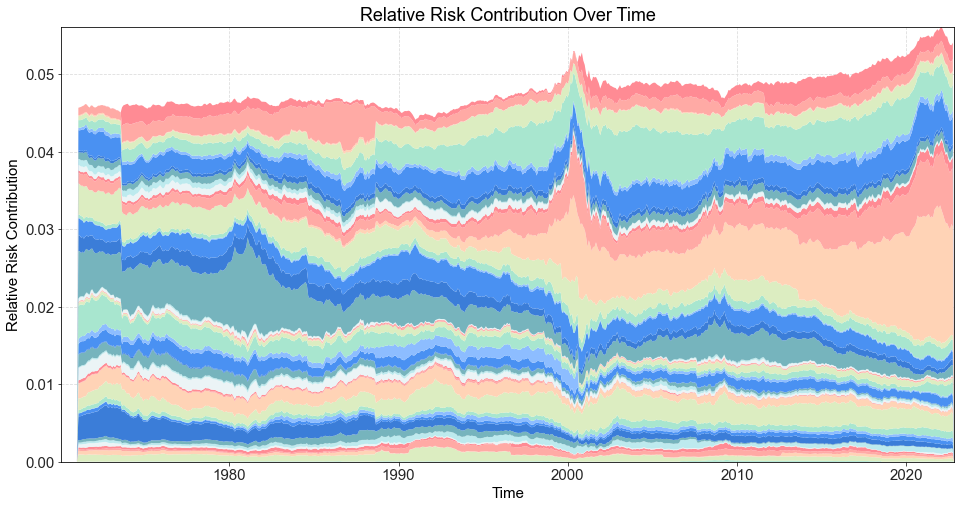

In [110]:
# Plot The Relative Risk Contribution

rel_risk_contrib = calculate_risk_contribution(weights_ENC, cov_mat_log_returns, 12)

fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(dates, rel_risk_contrib.T);
ax.set_xlabel("Time")
ax.set_ylabel("Relative Risk Contribution")
ax.set_title("Relative Risk Contribution Over Time");

In [114]:
# Choueifaty and Coignard (2008) Diversification Measure

def calculate_diversitifaction_measure(weights: np.ndarray, cov_matrix: np.ndarray, Months: int) -> np.ndarray:
    
    """
    Function that calculates relative risk contribution
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    """
    
    N = len(dates)
    diversification_vector = np.zeros_like(log_returns)
    
    for i in range(Months, N-1, 1):
        cov_matrix = cov_mat_log_returns
        weights_risk = weights[i-1,:] 
        sigma = 
    
        total_risk = np.sqrt(weights_risk @ cov_matrix @ weights_risk)
        numerator = weights_risk * sigma
        
        div = numerator / total_risk
        diversification_vector[i,:] = div
    
    return diversification_vector

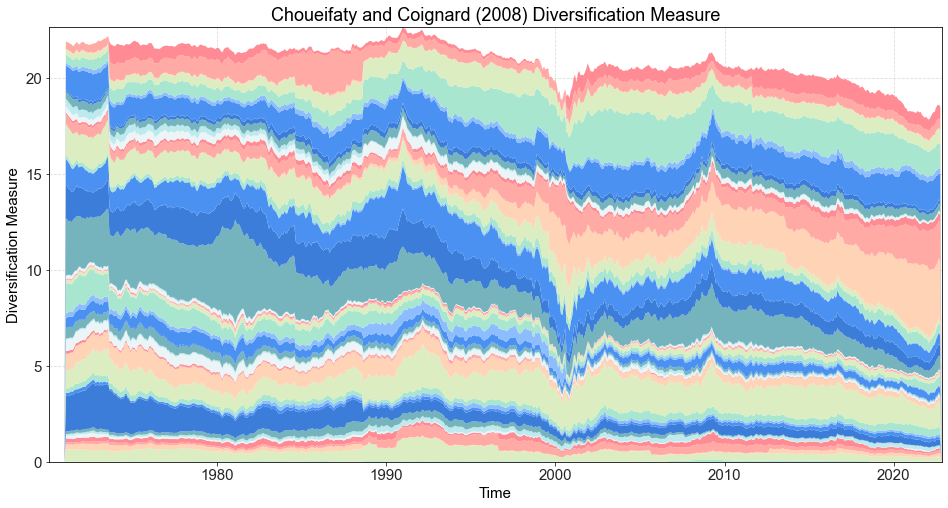

In [120]:
# Plot The CC Diversification Measure

diversification_measure = calculate_diversitifaction_measure(weights_ENC, cov_mat_log_returns, 12)

fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(dates, diversification_measure.T);
ax.set_xlabel("Time")
ax.set_ylabel("Diversification Measure")
ax.set_title("Choueifaty and Coignard (2008) Diversification Measure");